# Feedback Analysis

**Objective** - Given a set of reviews, we find group of reviews that are similar to each other and to display most common reviews/problems.

## Imports

In [6]:
import tensorflow as tf
import numpy as np
import pandas as pd
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import re
import gensim
import math

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec

## Loading Data

In [7]:
FILEPATH = input('Enter the path to csv Dataset : ')
HEADER = int(input('The number of rows in csv as header : '))
CSV_COLUMN_NAMES = ['Reviews']

Enter the path to csv Dataset : negative10k.csv
The number of rows in csv as header : 0


In [8]:
def load_data(header=0):
    """Parses the csv file and loads data into pandas DataFrame.
    
    Args:
      header: The number of header rows in csv.
      
    Returns:
      A DataFrame that contains the data.
    """
    
    # Parse the CSV file.
    data = pd.read_csv(filepath_or_buffer=FILEPATH,
                       names=CSV_COLUMN_NAMES,
                       header=header # ignores the no. of header rows
                       )
    # data now holds a pandas dataframe.
    
    return data

In [9]:
def display_sample(data):
    """Displays the length, shape and 5 rows of DataFrame.
    
    Args:
      data: A Pandas DataFrame of data.
    """
    print("The no. of rows   : ",len(data))
    print("The shape of data : ",data.shape)
    print(data.head())

In [10]:
# Load data
data = load_data(HEADER)

# Display sample from DataFrame
display_sample(data)

The no. of rows   :  9769
The shape of data :  (9769, 1)
                                             Reviews
0  Ya no I'd ur going make an app make sure it wo...
1  STUPID ADDS THE STUPID ADDS POP UP EVERY 5 SEC...
2  WTF Needs way more detail. 1. Sun should go do...
3  I love this game. But all of a sudden it when ...
4  Mark Now I can't send photo n images pls fix i...


## Text Cleaning

In [11]:
stop = set(stopwords.words('english')) # set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

print("The stopwords are : ", stop)

The stopwords are :  {'such', 'shan', 'did', 'these', 'can', 'mightn', 'it', "it's", "wouldn't", 'be', 'our', 'couldn', 'they', 'of', 'some', 'doesn', 'then', 'very', 'were', "she's", 'for', 'she', 'are', 'needn', 'theirs', 'had', 'didn', 'he', 'before', "you'll", 'both', "hadn't", 'wouldn', 'myself', 'above', 'after', "aren't", 'through', 'who', 'why', 'mustn', "didn't", 'where', "hasn't", 's', 'wasn', 'once', "mustn't", "needn't", 'or', 'have', 'all', 'there', 'will', 'been', 'again', 'at', 'am', 'than', 'off', 're', 'and', 'until', 'an', 'by', 'now', 'we', 'ain', 'aren', 'my', 'during', "wasn't", 'under', 'hers', 'themselves', 'y', 'hasn', 've', 'ourselves', 'do', 'their', 'yourself', 'a', "haven't", 'himself', 'o', 'being', 'here', "won't", 'don', 'has', 'm', 'your', 'not', 'yours', 'won', 'which', "should've", 'the', 'weren', 'i', 'ma', 'into', 'any', 'shouldn', 'is', 'if', 'from', 'what', 'them', 'isn', 'those', 'more', "you're", 'to', 'having', 'up', 'other', 'so', 'while', 'nor

In [12]:
def cleanhtml(sentence):
    """ Cleans the word of any html-tag.
    
    Args:
      sentence: Takes Sentence
      
    Returns:
      Sentence without any html tags in it.
    """
    cleanr = re.compile('<.*?')
    cleantext = re.sub(cleanr, ' ', sentence)
    
    return cleantext

In [13]:
def cleanpunc(sentence):
    """ Cleans the punctuation in the sentence.
    
    Args:
      sentence: A sentence
      
    Returns:
      A sentence after removing punctuations. 
    """
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    
    return  cleaned

In [14]:
def data_cleaning(data):
    """ Removes stop words, html, punctuation, numbers and articles.
    
    Args:
      data: A DataFrame containing data
      
    Returns:
      A DataFrame containing cleaned data
    """
    str1 = ' '
    final_string = []
    for review in data['Reviews'].values:
        filtered_sentence=[]
        review = cleanhtml(review) # remove HTML tags
        for word in review.split():
            for cleaned_words in cleanpunc(word).split(): # remove punctuation
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower()))
                        filtered_sentence.append(s)
                    else:
                        continue
                else:
                    continue
        str1 = ' '.join(filtered_sentence)
        final_string.append(str1)
    
    data['CleanedText'] = final_string
    
    return data

In [15]:
# Cleaning Data
data = data_cleaning(data)
display_sample(data)

The no. of rows   :  9769
The shape of data :  (9769, 2)
                                             Reviews  \
0  Ya no I'd ur going make an app make sure it wo...   
1  STUPID ADDS THE STUPID ADDS POP UP EVERY 5 SEC...   
2  WTF Needs way more detail. 1. Sun should go do...   
3  I love this game. But all of a sudden it when ...   
4  Mark Now I can't send photo n images pls fix i...   

                                         CleanedText  
0                         go make app make sure work  
1  stupid add stupid add pop everi second dumb ga...  
2  wtf need way detail sun anim tnt block diamond...  
3  love game sudden play next episod play stupid ...  
4             mark cant send photo imag pls fix icon  


## Text Preprocessing: Converting text into vectors using Word2Vec

In [16]:
def train_Word2Vec_model(data):
    """Trains Word2Vec model on our Dataset.
    Prints the vocabulary size.
    
    Args:
      data: A dataframe containing data
      
    Returns:
      w2v_model: Word2Vec model object
      list_of_sent: A list of list of words in reviews
    """
    list_of_sent = []
    for sent in data['CleanedText'].values:
        filtered_sentence=[]
        for w in sent.split():
            filtered_sentence.append(w)
        list_of_sent.append(filtered_sentence)
    
    # For Testing Purposes Only
    print(data['CleanedText'].values[0])
    print("**************************************")
    print(list_of_sent[0])
    
    # Train w2v model
    w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50,workers=4)
    
    # Creating list of words from vocabulary
    words = list(w2v_model.wv.vocab)
    print("\n\n The no. of words in vocabulary : ",len(words))
    
    return w2v_model, list_of_sent

In [17]:
# Creating Word2Vec model
w2v_model, list_of_sent = train_Word2Vec_model(data)

go make app make sure work
**************************************
['go', 'make', 'app', 'make', 'sure', 'work']


 The no. of words in vocabulary :  1952


**Compute average word2vec for each review.**

In [18]:
def review_to_vector(w2v_model, data):
    """Computes average word2vec for each review.
    
    Args:
      w2v_model: Word2Vec model for creating vector for reviews.
      
    Returns:
      A Dataframe with added avg word2vec for each review.
    """
    sent_to_vectors = [] # for storing the avg-w2v for each review
    for sent in list_of_sent: # for each review
        sent_vec = np.zeros(50)
        cnt_words = 1 # num of valid words in review according to our word2vec model
        for word in sent: # for each word in a review/sentence
            try:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
            except:
                pass
        sent_vec /= cnt_words # taking average
        sent_to_vectors.append(sent_vec)
    data['Vector'] = sent_to_vectors
    
    return data

In [19]:
# Computing avg word2vec for each review
data = review_to_vector(w2v_model, data)
display_sample(data)

The no. of rows   :  9769
The shape of data :  (9769, 3)
                                             Reviews  \
0  Ya no I'd ur going make an app make sure it wo...   
1  STUPID ADDS THE STUPID ADDS POP UP EVERY 5 SEC...   
2  WTF Needs way more detail. 1. Sun should go do...   
3  I love this game. But all of a sudden it when ...   
4  Mark Now I can't send photo n images pls fix i...   

                                         CleanedText  \
0                         go make app make sure work   
1  stupid add stupid add pop everi second dumb ga...   
2  wtf need way detail sun anim tnt block diamond...   
3  love game sudden play next episod play stupid ...   
4             mark cant send photo imag pls fix icon   

                                              Vector  
0  [-0.16150996035763196, 0.567125950540815, -0.2...  
1  [-0.26620166135184903, 0.4829488843679428, -0....  
2  [-0.16362265528490147, 0.42710165369013947, -0...  
3  [-0.183073284468897, 0.5926612265731978, -0.19

## Using K-means Clustering in Tensorflow

In [20]:
def create_input_tensor(data):
    """Creates tensor from pandas dataframe.
    
    Args:
      data: A pandas DataFrame of data.
    
    Returns:
      features: A tensor containing all points.
    """
    points = list(data['Vector'])
    print(points)
    features = tf.constant(np.array(points), tf.float32) # Creating tensorflow constant
    
    return features

In [102]:
features = create_input_tensor(data)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [103]:
def KMeans(k, points):
    """Implement KMeans Clustering on points and plots a scatter plot.
    
    Args:
      k: the number of clusters
      points: A tensor containing input 
    
    Returns:
    """
    
    # Randomnly choose initial centroids from the set of data points.
    # centroids = tf.Variable(tf.slice(tf.random_shuffle(points), [0,0], [k, -1]))
    centroids = tf.Variable(tf.slice(points, [0,0], [k, -1]))
    
    # To be able to do element-wise subtraction of points and centroids that are 2D tensors,
    # because the tensors have different shape, let's expand points and centroids into 3D tensors
    # which allows us to use broadcasting feature of subtraction.
    points_expanded = tf.expand_dims(points, axis=0)
    centroids_expanded = tf.expand_dims(centroids, axis=1)
    
    # Calculate the distances between points and centroids and determine the cluster assignments.
    distances = tf.reduce_sum(tf.square(tf.subtract(points_expanded, centroids_expanded)), 2)
    assignments = tf.argmin(distances, 0)  
    
    # Compare each cluster with a cluster assignments vector
    # Get points assigned to each cluster and calculate mean values.
    # These mean are better centroids, so updating the centroids 
    
    means = []
    for c in range(k):
        means.append(tf.reduce_mean(
            tf.gather(points,
                     tf.reshape(
                         tf.where(
                             tf.equal(assignments, c)
                         ), [1,-1])
                     ),reduction_indices=[1]))
    new_centroids = tf.concat(means, 0)
    update_centroids = tf.assign(centroids, new_centroids)
    init = tf.global_variables_initializer()
        
    # For each iteration, we update the centroids and return their values along with the cluster values.
    with tf.Session() as sess:
        sess.run(init)
        for step in range(100):
            [_, centroid_values, point_values, assignment_values] = \
                sess.run([update_centroids, centroids, points, assignments])


    plt.scatter(point_values[:, 0], point_values[:, 1], c=assignment_values, s=50, alpha=0.5)
    plt.plot(centroid_values[:, 0], centroid_values[:, 1], 'kx', markersize=15)
    plt.title('K = {k} '.format(k=k))
    plt.show()
    return centroid_values, point_values, assignment_values

In [104]:
def SE(point, centroid):
    """Calculates the squared error.
    
    Agrs: 
      point: A point with n-dimensions.
      centroid: Another point with same dimensions as points from which the distance is to be calculated.
      
    Returns:
      distance: The distance from the centroid.
    """
    distance = 0
    for p, c in zip(point, centroid):
        distance += math.pow(p-c,2)
    return distance   

In [105]:
def elbow_method(points):
    """The idea of elbow method is to run k-means clustering with different k to find best 'k'.
    
    Args:
      points: A tensor of points
    """
    
    SSE = [0]*15 # for storing Sum of Squared Errors(SSE) for each k
    for k in range(2,15):
        centroid_values, point_values, assignment_values = KMeans(k, points)
        for counter, point in enumerate(point_values): 
            SSE[k] += SE(list(point), list(centroid_values[assignment_values[counter]]))
            
    plt.plot([2,3,4,5,6,7,8,9,10,11,12,13,14],SSE[2:],marker='o')
    plt.xlabel('k clusters')
    plt.ylabel('SSE')
    plt.title('The elbow method')
    plt.show()

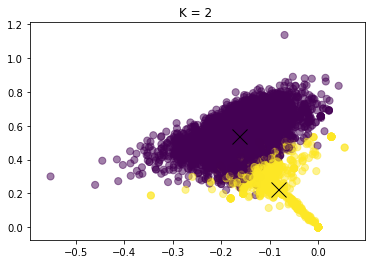

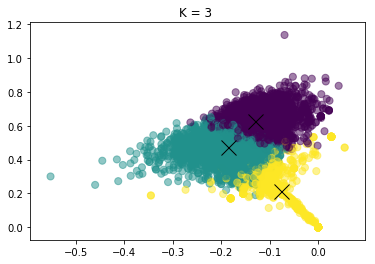

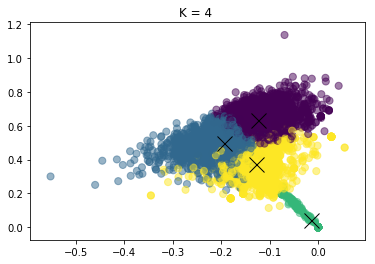

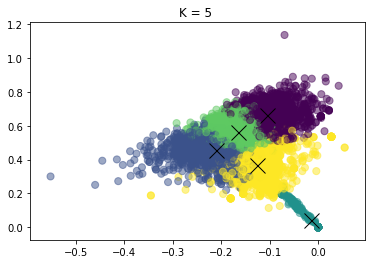

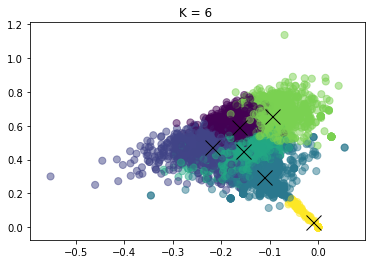

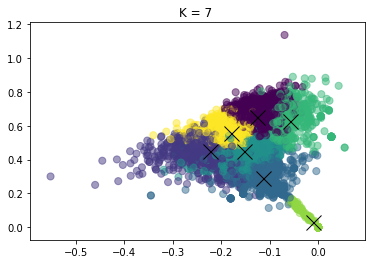

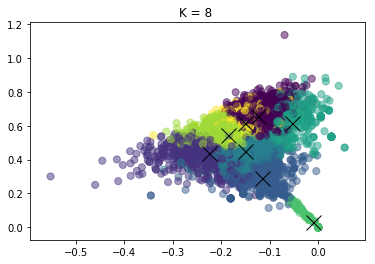

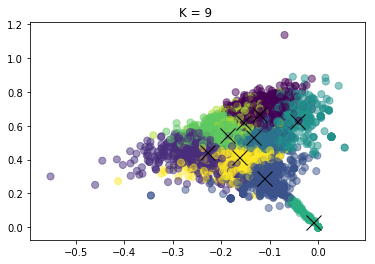

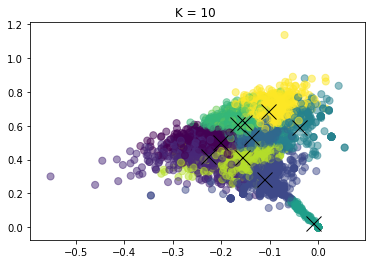

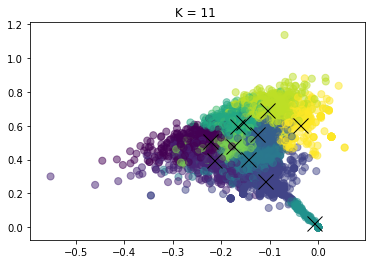

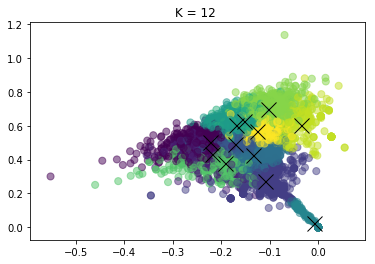

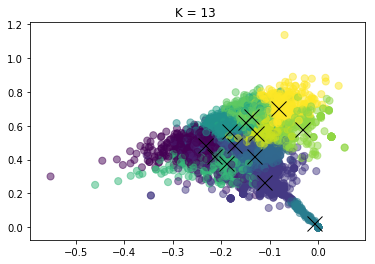

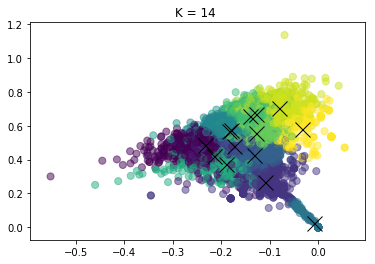

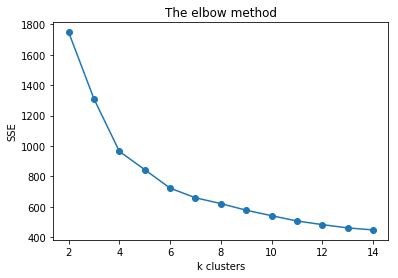

In [106]:
elbow_method(features)

## Adjust k value for Analyzing

After observing the **The elbow method graph** above, adjust to the best value of *K* below. The best value is the one which has bend just like elbow.

For eg - In the graph below, the best **K value is 6**.

![The elbow method](the_elbow_method_sample.jpeg)

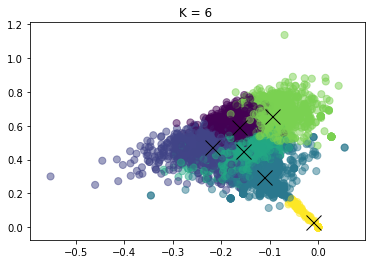

In [193]:
# After observing the elbow method graph, change K to suitable value.
K = 6
centroid_values, point_values, assignment_values = KMeans(K, features)

In [206]:
def list_problems(k, centroid_values, point_values, assignment_values, data):
    """Display the problem from each cluster and plot the graph.
    
    Args: 
      k: The number of clusters.
      centroid_values: The list containing the n-dimensional centroids of clusters.
      point_values: The list of n-dimensional points.
      assignment_values: The list containing the cluster assigned to each point.
      data: The pandas DataFrame containing data
    """ 
    data['Cluster'] = assignment_values
    least_distance = [[10000]*2 for _ in range(k)] # for storing closest point to the centroid along with position. Hence 2d array.
    for counter, point in enumerate(point_values):
        distance = math.sqrt(SE(point,centroid_values[assignment_values[counter]]))
        if distance<least_distance[assignment_values[counter]][0]:
            least_distance[assignment_values[counter]][0] = distance
            least_distance[assignment_values[counter]][1] = counter
        else:
            continue
            
    print("The most common reviews/problems are as follows: \n\n")
    for i in range(k):
        print("Problem ",i+1," : ",data['Reviews'][least_distance[i][1]])
        
    count = data['Cluster'].value_counts()
    x = []
    y = []
    for i in range(k):
        x.append("Problem "+str(i))
        y.append(count[i])
    
    X = np.arange(1,k+1)
    plt.bar(X,y,alpha=0.5)
    plt.xlabel('Problem No.')
    plt.ylabel('No. of reviews')
    plt.grid()
    # plt.xticks(X,x)
    plt.show()

The most common reviews/problems are as follows: 


Problem  1  :  Very aggravating when u try to log in and it kicks u off everytime. Getting really old ..then they tell me it's my fault Don't think so I love the game ..WHEN it works Otherwise it sucks anymore Fix UR problem tinyco

Problem  2  :  No good I as an adult had a hard time understanding how to play the game.  Once I figured it out the game shut down halfway through each snowcone build. I don't think my 4 year old was going to enjoy it.

Problem  3  :  Bosan Boleh tak lain kali main game ne tk pyh nak beli pakai point..cuma pakai duit jer..tak enjoy lah main kalau macam ini.

Problem  4  :  7.4 has huge bugs No access to rooms, chats don't appear at all. Here's a novel idea, you should maybe test apps before publishing them

Problem  5  :  Pykl3 radar Cannot get this app to open on my new Samsung Galaxy s6 Active. I have uninstalled it and cleared the cache several times but it refuses to open. It worked great before on my 

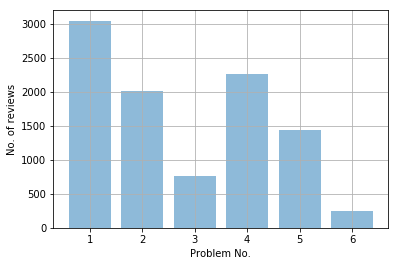

In [207]:
list_problems(K, centroid_values, point_values, assignment_values, data)